In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

#### reading data

In [16]:
columns = [
    "status", "duration", "credit_history", "purpose", "credit_amount",
    "savings", "employment", "installment_rate", "personal_status_sex",
    "other_debtors", "residence_since", "property", "age",
    "other_installment", "housing", "existing_credits", "job",
    "num_dependents", "telephone", "foreign_worker", "credit_risk"
]

df = pd.read_csv(
    r"C:\Users\kawee\Downloads\statlog+german+credit+data\german.data",
    sep=" ",
    names=columns
)

df.head()

,status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment,housing,existing_credits,job,num_dependents,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


#### DESCRIPTIVE ANALYSIS

In [74]:
df.shape

(1000, 23)

In [76]:
df.describe()

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_dependents,credit_risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


In [18]:
# Binary target: 1 = Bad credit
df["credit_risk"] = df["credit_risk"].apply(lambda x: 1 if x == 2 else 0)

# Extract sensitive attributes
df["gender"] = df["personal_status_sex"].apply(
    lambda x: "male" if x in ["A91","A93","A94"] else "female"
)

df["age_group"] = df["age"].apply(lambda x: "young" if x < 25 else "adult")

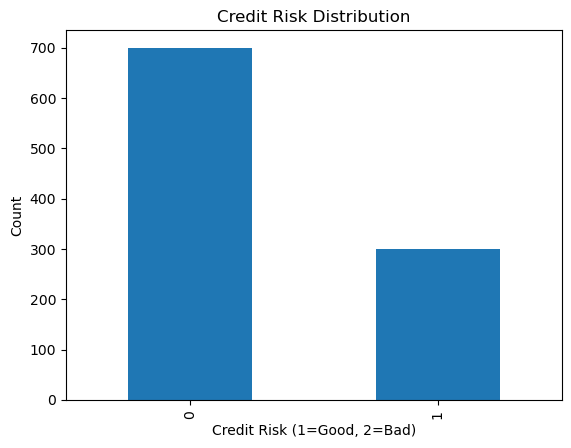

In [78]:
import matplotlib.pyplot as plt

df["credit_risk"].value_counts().plot(
    kind="bar",
    title="Credit Risk Distribution",
    xlabel="Credit Risk (1=Good, 2=Bad)",
    ylabel="Count"
)
plt.show()

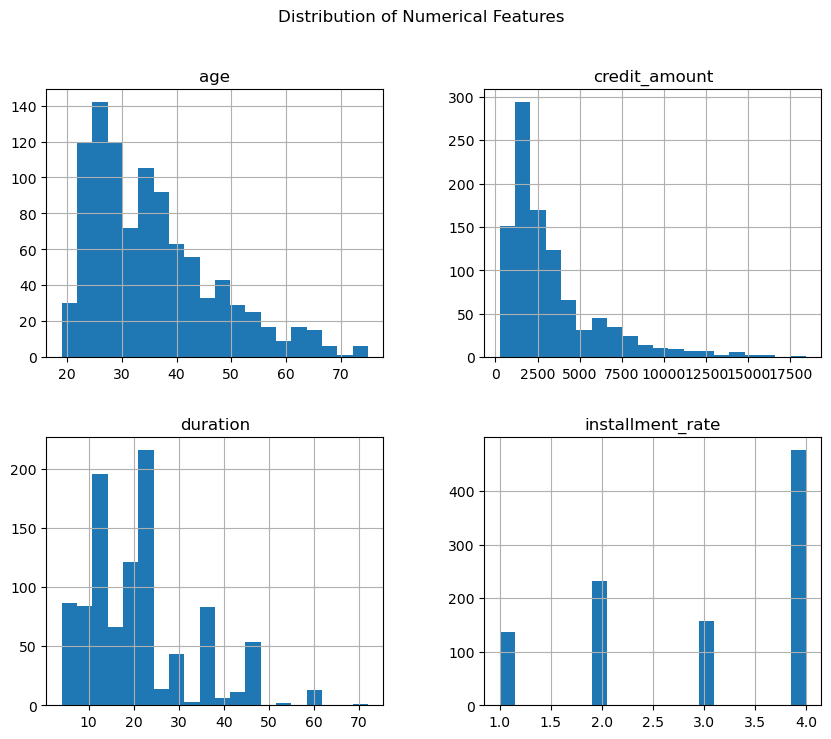

In [80]:
num_cols = ["age", "credit_amount", "duration", "installment_rate"]

df[num_cols].hist(bins=20, figsize=(10,8))
plt.suptitle("Distribution of Numerical Features")
plt.show()

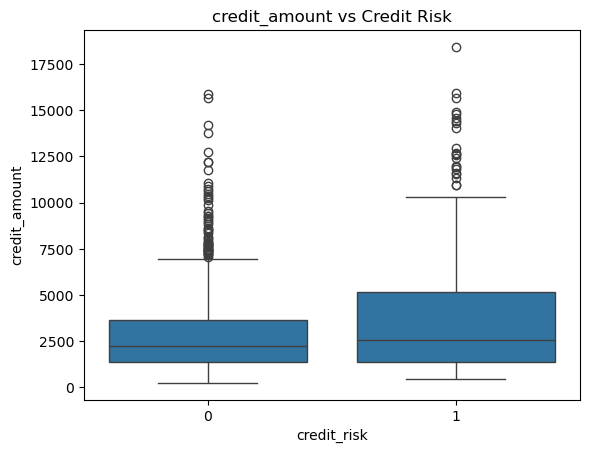

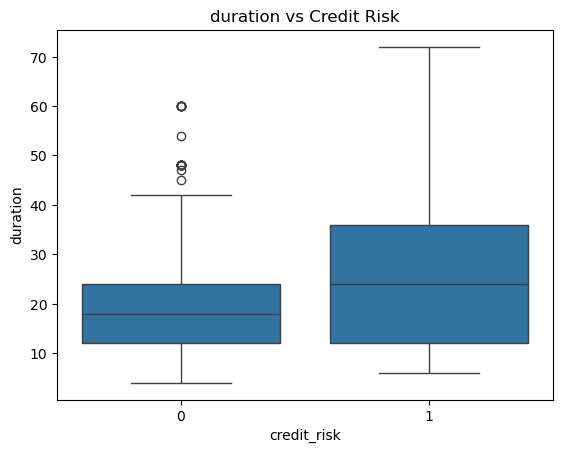

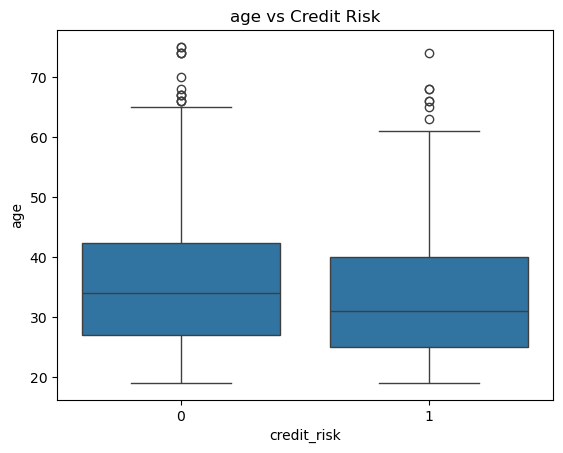

In [82]:
import seaborn as sns

for col in ["credit_amount", "duration", "age"]:
    sns.boxplot(x="credit_risk", y=col, data=df)
    plt.title(f"{col} vs Credit Risk")
    plt.show()

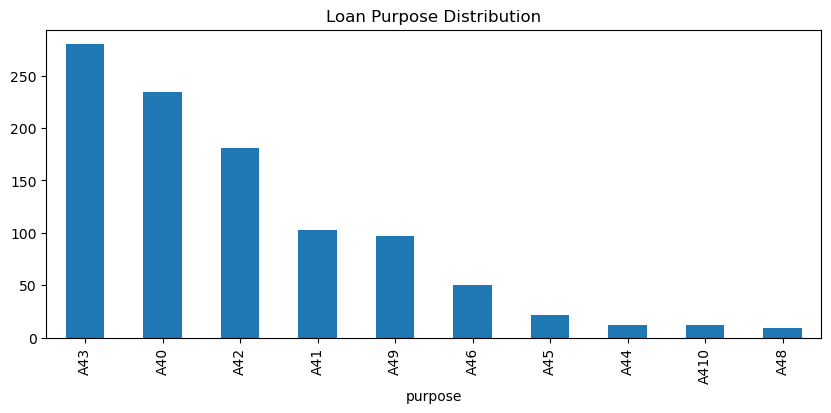

In [84]:
df["purpose"].value_counts().plot(
    kind="bar",
    figsize=(10,4),
    title="Loan Purpose Distribution"
)
plt.show()

In [86]:
df["gender"] = df["personal_status_sex"].apply(
    lambda x: "male" if x in ["A91","A93","A94"] else "female"
)

df["gender"].value_counts(normalize=True)

gender
male      0.69
female    0.31
Name: proportion, dtype: float64

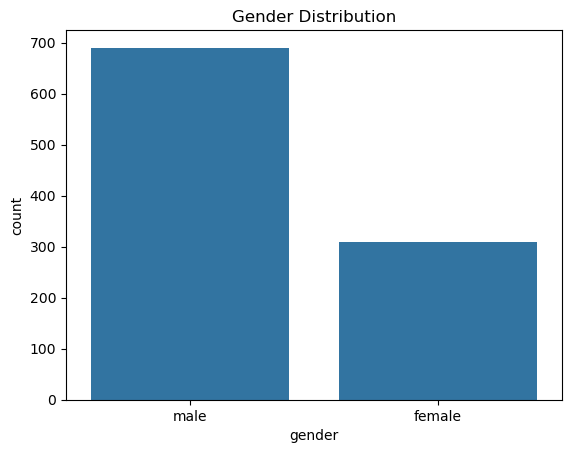

In [88]:
sns.countplot(x="gender", data=df)
plt.title("Gender Distribution")
plt.show()

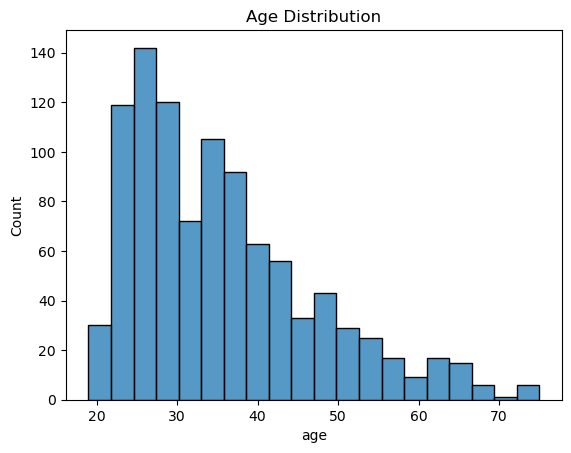

In [90]:
sns.histplot(df["age"], bins=20)
plt.title("Age Distribution")
plt.show()

#### STATISTICAL TESTS

In [103]:
from scipy.stats import ttest_ind

good = df[df["credit_risk"] == 0]["credit_amount"]
bad  = df[df["credit_risk"] == 1]["credit_amount"]

t_stat, p_val = ttest_ind(good, bad, equal_var=False)
t_stat, p_val

(-4.264219416732966, 2.477713335048265e-05)

In [105]:
good_age = df[df["credit_risk"] == 0]["age"]
bad_age  = df[df["credit_risk"] == 1]["age"]

ttest_ind(good_age, bad_age, equal_var=False)

TtestResult(statistic=2.9071521165499394, pvalue=0.0037884908809601527, df=573.0555031327876)

In [99]:
#chi
from scipy.stats import chi2_contingency

ct_gender = pd.crosstab(df["gender"], df["credit_risk"])
chi2, p, dof, _ = chi2_contingency(ct_gender)

chi2, p

(5.348516218081436, 0.020739913068713305)

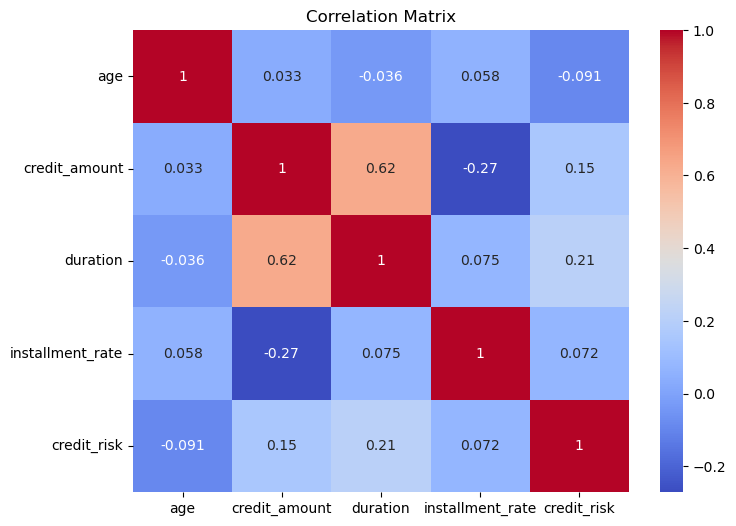

In [101]:
corr = df[num_cols + ["credit_risk"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [20]:
X = df.drop(columns=["credit_risk", "gender", "age_group"])
y = df["credit_risk"]

cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [24]:
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X,
    y,
    df[["gender", "age_group"]],
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [26]:
model = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        class_weight="balanced",
        solver="liblinear"
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['duration', 'credit_amount', 'installment_rate', 'residence_since',
       'age', 'existing_credits', 'num_dependents'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['status', 'credit_history', 'purpose', 'savings', 'employment',
       'personal_status_sex', 'other_debtors', 'property', 'other_installment',
       'housing', 'job', 'telephone', 'foreign_worker'],
      dtype='object'))])),
                ('clf',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [28]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.7266666666666667
ROC-AUC: 0.8034920634920635


In [30]:
approval = (y_prob < 0.4).astype(int)
results = sens_test.copy()
results["approved"] = approval
results["actual"] = y_test.values

In [32]:
fairness_gender = results.groupby("gender")["approved"].mean()
fairness_gender

gender
female    0.425743
male      0.527638
Name: approved, dtype: float64

In [34]:
di_gender = fairness_gender["female"] / fairness_gender["male"]
print("Disparate Impact (Gender):", round(di_gender, 3))

Disparate Impact (Gender): 0.807


In [50]:
fairness_metrics = pd.DataFrame({
    "Metric": ["Approval Rate (Female)", "Approval Rate (Male)", "Disparate Impact"],
    "Value": [
        round(fairness_gender["female"], 3),
        round(fairness_gender["male"], 3),
        round(di_gender, 3)
    ]
})

fairness_metrics

,Metric,Value
0,Approval Rate (Female),0.426
1,Approval Rate (Male),0.528
2,Disparate Impact,0.807


In [52]:
for t in [0.35, 0.4, 0.45]:
    approval_t = (y_prob < t).astype(int)
    temp = sens_test.copy()
    temp["approved"] = approval_t
    di = (
        temp.groupby("gender")["approved"].mean()["female"] /
        temp.groupby("gender")["approved"].mean()["male"]
    )
    print(f"Threshold {t}: DI = {round(di,3)}")

Threshold 0.35: DI = 0.759
Threshold 0.4: DI = 0.807
Threshold 0.45: DI = 0.791


In [36]:
fairness_age = results.groupby("age_group")["approved"].mean()
fairness_age

age_group
adult    0.531120
young    0.338983
Name: approved, dtype: float64

In [38]:
di_age = fairness_age["young"] / fairness_age["adult"]
print("Disparate Impact (Age):", round(di_age, 3))

Disparate Impact (Age): 0.638


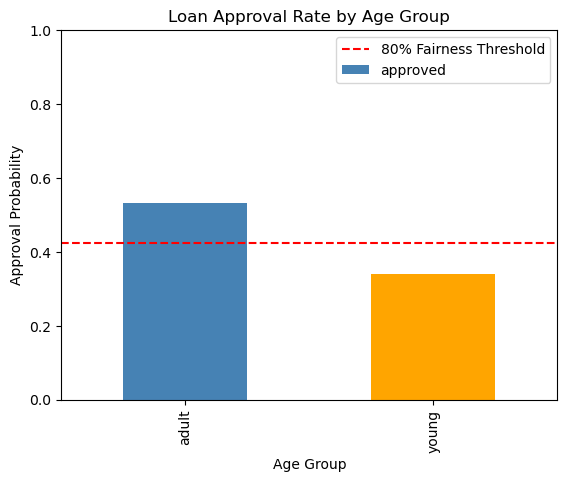

In [54]:
fairness_age.plot(
    kind="bar",
    title="Loan Approval Rate by Age Group",
    ylabel="Approval Probability",
    xlabel="Age Group",
    ylim=(0,1),
    color=["steelblue", "orange"]
)
plt.axhline(
    0.8 * fairness_age["adult"],
    color="red",
    linestyle="--",
    label="80% Fairness Threshold"
)
plt.legend()
plt.show()

In [60]:
results["adjusted_approved"] = np.where(
    (results["age_group"] == "young") & (y_prob < 0.45),
    1,
    results["approved"]
)

new_fairness_age = results.groupby("age_group")["adjusted_approved"].mean()
new_di_age = new_fairness_age["young"] / new_fairness_age["adult"]

new_di_age

0.8297139830508474

In [64]:
mitigation_summary = pd.DataFrame({
    "Age Group": ["Young vs Adult"],
    "DI (Before Mitigation)": [round(di_age, 3)],
    "DI (After Threshold Adjustment)": [round(0.829, 3)],
    "80% Rule Status (After)": ["Pass"]
})

mitigation_summary

,Age Group,DI (Before Mitigation),DI (After Threshold Adjustment),80% Rule Status (After)
0,Young vs Adult,0.638,0.829,Pass


In [62]:
def true_positive_rate(df):
    tp = ((df["approved"] == 1) & (df["actual"] == 0)).sum()
    fn = ((df["approved"] == 0) & (df["actual"] == 0)).sum()
    return tp / (tp + fn)

tpr_gender = results.groupby("gender").apply(true_positive_rate)
tpr_gender

C:\Users\kawee\AppData\Local\Temp\ipykernel_24272\425001449.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tpr_gender = results.groupby("gender").apply(true_positive_rate)


gender
female    0.606061
male      0.652778
dtype: float64

In [42]:
print("Equal Opportunity Difference:", round(tpr_gender["female"] - tpr_gender["male"], 3))

Equal Opportunity Difference: -0.047


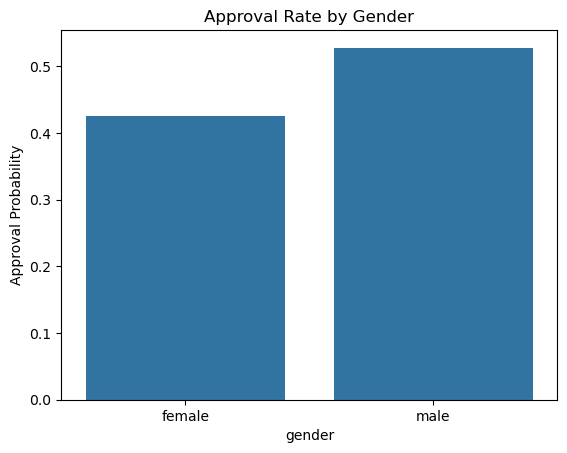

In [44]:
sns.barplot(
    x=fairness_gender.index,
    y=fairness_gender.values
)
plt.title("Approval Rate by Gender")
plt.ylabel("Approval Probability")
plt.show()

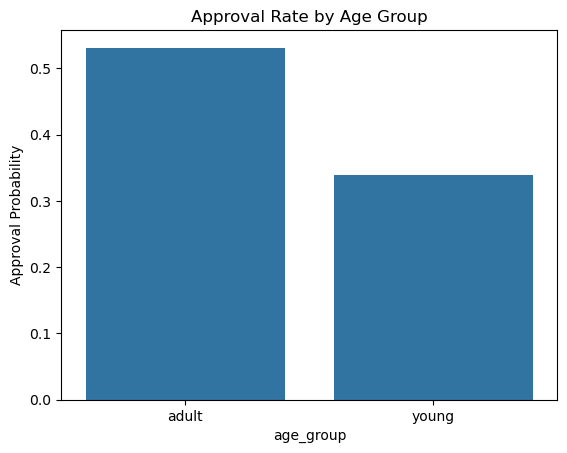

In [46]:
sns.barplot(
    x=fairness_age.index,
    y=fairness_age.values
)
plt.title("Approval Rate by Age Group")
plt.ylabel("Approval Probability")
plt.show()

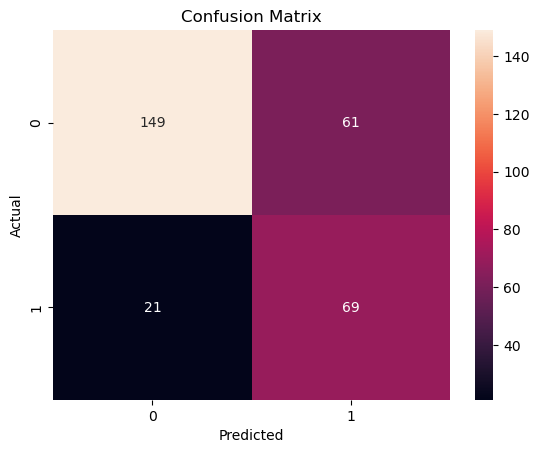

In [70]:
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

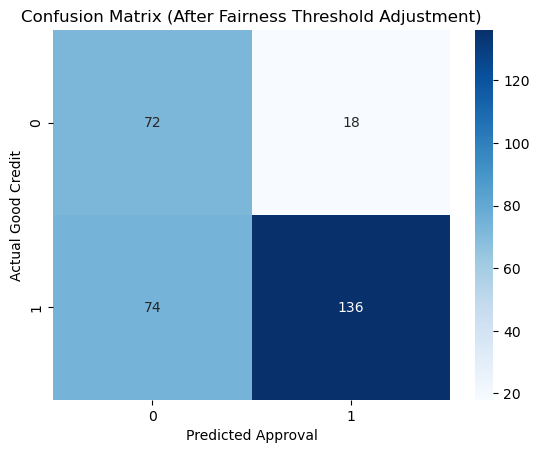

In [72]:
# Adjusted predictions AFTER fairness mitigation
y_pred_adjusted = results["adjusted_approved"].values

y_actual_good = (y_test == 0).astype(int)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_adjusted = confusion_matrix(y_actual_good, y_pred_adjusted)

sns.heatmap(
    cm_adjusted,
    annot=True,
    fmt="d",
    cmap="Blues"
)

plt.title("Confusion Matrix (After Fairness Threshold Adjustment)")
plt.xlabel("Predicted Approval")
plt.ylabel("Actual Good Credit")
plt.show()